
# PAC learning : Bias-variance trade-off,  $L_{emp}$, $L_{CV}$ and $L_{GCV}$ 

## Load packages


In [2]:
import numpy as np
import scipy as sp
import random as r
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import os

# Data generation process

In [3]:


# Fix some general setup variables

r.seed(201053)

# sample size n 

n = 100

# Monte Carlo iterations J

J = 10

 # number  of repetitions for the CV exercise J_cv 

J_cv = 1      

# noise variance

sig2 = 0.3

# Define colors

col_pink = 'hotpink'
col_blue = 'b'
col_red  = 'indianred'
col_navy = 'navy'


## 1. Generate  X$\sim U [0,1]$

In [4]:
x = sp.random.uniform(0,1,n)
x.sort()

## 2. Generate $y_i = \sin^3(2\pi x_i^3) + \varepsilon_i,  i\in [1,n]$, where $\varepsilon_i \sim N(0,\sigma_\varepsilon^2)$ and $\sigma^2_\varepsilon = 0.1$



2a) Generate $\varepsilon_i \sim N(0,\sigma_\varepsilon^2)$ with $\sigma^2_\varepsilon $ to be determined

In [5]:
# Only for illustration - regenerated in next block!

sigma = np.sqrt(sig2)
eps = np.random.normal(0, sigma,  n)

2b) Generate $y_i = \sin^3(2\pi x_i^3) + \varepsilon_i$ for $i\in 1:n$

In [6]:
def f(x):
    return (np.sin(2*np.pi*(x**3)))**3

def gendata(f, sigma, n):
    return ( f + np.random.normal(0, sigma, n) ) 
            
f_x = f(x)
y = gendata(f_x, sigma, n)

## Data plot

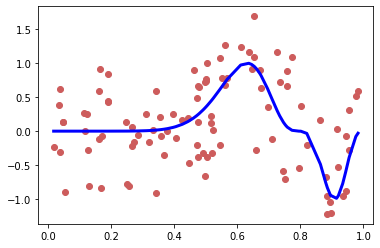

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'o', color=col_red)
ax.plot(x,f_x,'-g',color=col_blue, lw=3)

# Kernel regression smoothing with NW kernel estimator

## Smoothing with Gaussian Kernel

In this task we choose $K_h$ to be a Gaussian Kernel. The Naradaya Watson (NW)
estimator is given by
\begin{align}
\hat{f}_h(t):=\sum_{i=1}^n\frac{K_h(t-x_i)}{\sum_{i=1}^nK_h(t-x_i)}Y_i
\end{align}


In [8]:
# Naradaya-Watson at points t, a mesh of grid points
def nw_inner(t, x, y, h):
    K_h = norm.pdf( (t-x)/h )/h
    den = sum(K_h)
    w   = K_h/den
    nw  = np.dot(w, y) 
    return nw

# f_h estimation 
def fh(ts, x, y, h):
    return [nw_inner(t, x ,y ,h) for t in ts]


In [9]:
# trial bandwidth for Gaussian kernel, note that in terms of Uni (box car) kernel 
# this has to be multiplied with 1.35/0.77, i.e. we for h=0.01 are averaging over the window (t - 0.0175, t + 0.0175)
# LM change the NW smoother !!!! 

h = 0.02

# NW estimation

f_h = fh(x, x, y, h) 

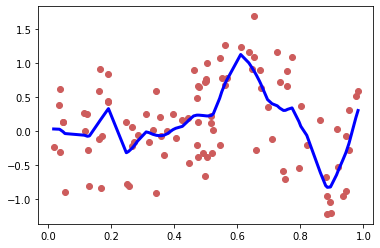

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'o', color= col_red)
ax.plot(x,f_h,'-g',color= col_blue, lw=3)

# Bias-variance decomposition

\begin{equation}
\begin{aligned}
\mathrm{E}\left[(y-\hat{f})^{2}\right] &=\mathrm{E}\left[y^{2}+\hat{f}^{2}-2 y \hat{f}\right]=\mathrm{E}\left[y^{2}\right]+\mathrm{E}\left[\hat{f}^{2}\right]-\mathrm{E}[2 y \hat{f}] \\
&=\operatorname{Var}[y]+\mathrm{E}[y]^{2}+\operatorname{Var}[\hat{f}]+\mathrm{E}[\hat{f}]^{2}-2 f \mathrm{E}[\hat{f}]=\operatorname{Var}[y]+\operatorname{Var}[\hat{f}]+(f-\mathrm{E}[\hat{f}])^{2} \\
&=\operatorname{Var}[y]+\operatorname{Var}[\hat{f}]+\mathrm{E}[f-\hat{f}]^{2}=\sigma^{2}+\operatorname{Var}[\hat{f}]+\operatorname{Bias}[\hat{f}]^{2}
\end{aligned}
\end{equation}

Source: Wikipedia

Estimation for some bandwidths e.g. $h \in [0.01, 0.02, \dots, 0.1]$

In [11]:
h = list( np.linspace(0.01, 0.3, 25) )


## Find $\hat{f}$ 
Kernel regression for all bandwidths

Bias: $\mathrm{E}[\hat{f} - f] =  \mathrm{E}[\hat{f}]  - f $

Variance: $E\left[\hat{f}-\mathrm{E} \hat{f}\right]^{2}$

In [12]:
# Repeat data generation J times

f_h = np.zeros( (n, len(h)) )
E_fh =  np.zeros( (n, len(h)) )
bias = np.zeros( (n, len(h)) )
variance = np.zeros( (n, len(h)) )
CV = np.zeros( len(h) )
CV_all = np.zeros( (J_cv, len(h)) )   # collects the CVs over simulations
L_emp = np.zeros( (J_cv, len(h)) )    # collects the emp error over simulations


In [13]:
#  Computation of bias

r.seed(201053)      # fix seed to have bias and variance calculated on the same random set

for j in range(1, J):
    y = gendata(f_x, sigma, n)
    for i in range(len(h)):
        f_h[:,i] = fh(x, x, y, h[i])
        E_fh[:,i] = E_fh[:,i] + f_h[:,i] 
    # end h loop
        
# end J loop

E_fh = E_fh/J

# now calc bias
for i in range(len(h)):
    bias[:,i] = E_fh[:,i] - f_x
    # end h loop

bias2 = bias**2
Int_bias_h = np.sum(bias2, axis = 0)/n

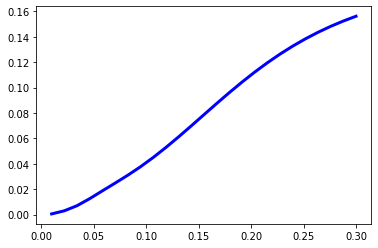

In [14]:
plt.plot(h, Int_bias_h, color=col_blue, lw = 3)

In [15]:
r.seed(201053)
for j in range(1,J):
    y = gendata(f_x, sigma, n)
    for i in range(len(h)):
        f_h[:,i] = fh(x, x, y, h[i])
        variance[:,i] = variance[:,i] +  (f_h[:,i]  - E_fh[:,i])**2
    # end h loop
        
# end J loop  

variance = variance/J

Int_var_h = np.sum(variance, axis = 0)/n 

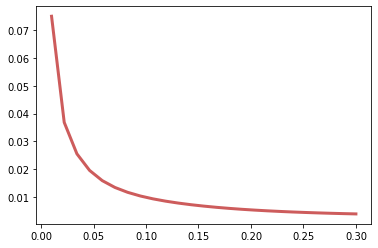

In [16]:
plt.plot(h, Int_var_h, color=col_red, lw = 3)

Plot bias-variance-tradeoff

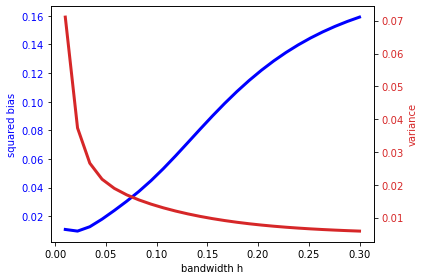

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('bandwidth h')
ax1.set_ylabel('squared bias', color=col_blue)
ax1.plot(h, Int_bias_h, color=col_blue, lw = 3)
ax1.tick_params(axis='y', labelcolor=col_blue)

ax2 = ax1.twinx()  

col_red = 'tab:red'
ax2.set_ylabel('variance', color=col_red)  
ax2.plot(h, Int_var_h, color=col_red, lw = 3)
ax2.tick_params(axis='y', labelcolor=col_red)

fig.tight_layout()  
plt.show()

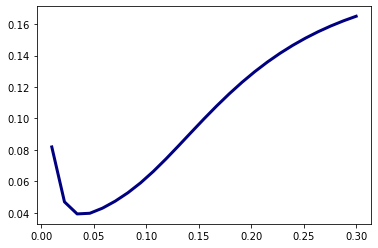

In [17]:
plt.plot(h, Int_bias_h + Int_var_h, color = col_navy, lw=3)

## Cross-validation

Estimate 
\begin{equation}
\hat{f}_{h,-i\,}(x_i) = \sum_{j\ne i} \frac{K_h(x_i-x_j)}{{\sum_{k\ne i} K_h(x_i-x_k)}}\,y_j
\end{equation}

In [18]:
r.seed(201053)      # fix seed to have bias and variance calculated on the same random set

for j in range(J_cv):
    y = gendata(f_x, sigma, n)
    for i in range( len(h) ):
        f_l = 0
        for l in range( len(x) ):
            x_l = np.delete(x, l,  axis = 0)
            y_l = np.delete(y, l,  axis = 0)
            u = fh([x[l]], x_l, y_l, h[i]) 
            f_l = f_l + (y[l] - u)**2 
          
            # end l loop over obs
        CV[i] = f_l
        
    # end h loop
    
        CV_all[j, i] = CV[i]/n
# end J loop
CV_mean = np.mean( CV_all, axis = 0 )

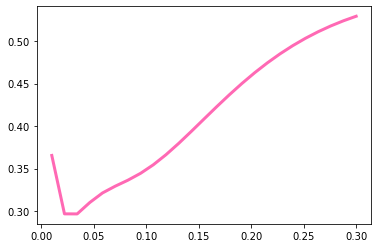

In [19]:
plt.plot(h, CV_mean, lw = 3,  color = col_pink)
#plt.plot(h,L_emp)
#plt.plot(h,[sigma**2]*len(h))

In [20]:
r.seed(201053)

for j in range(J_cv):
    y = gendata(f_x, sigma, n)
    for i in range(  len(h) ):
        f_h[:,i] = fh(x, x, y, h[i])
        L_emp[j,i] = np.mean( (y - f_h[:,i])**2 , axis = 0)
    # end h loop

# end J loop  

L_emp = L_emp/J_cv
L_emp_mean = np.mean( L_emp, axis = 0 )

## Generalized Cross-validation

\begin{equation}
L^\mathrm{GCV}(\hat{f}_h) = GCV(h)=
\frac{1}{\left[1-\mathrm{tr}\{S(h)\}/n
\right]^2}\,L_\mathrm{emp}(\hat{f}_h) \rightarrow \min_{h\in \mathbb{R}} 
\end{equation}

for the hat matrix $$\mathrm{tr}\{S(h)\} = \sum_{i=1}^n s_{ii}= n^{-1} K_h(0) \sum_{i=1}^n\{n^{-1} {\sum_{k=1}^n K_h(x_i-x_k)}\}^{-1}$$
We know that 
$\mathrm{tr}\{S(h)\} \approx h^{-1} K(0)$



In [21]:
inner_t = (norm.pdf(0)/h)/n      # tr( S(h)/n )

L_GCV = L_emp/( (1-inner_t)**2 )

L_GCV_mean = np.mean( L_GCV, axis = 0 )

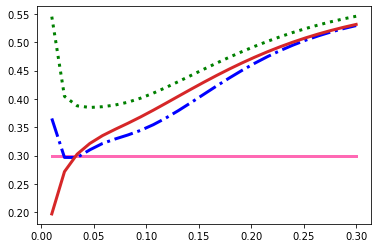

In [22]:
plt.plot(h, sig2 + np.zeros( len(h) ), color=col_pink, lw=3)
plt.plot(h, CV_mean,linestyle='dashdot', color=col_blue, lw=3)
plt.plot(h, L_emp_mean, color= col_red, lw=3)
plt.plot(h, L_GCV_mean, linestyle='dotted', color = 'green', lw=3)